## PCA Visualized

Wine Dataset: https://archive.ics.uci.edu/ml/datasets/wine

Citation: https://archive.ics.uci.edu/ml/citation_policy.html

In [1]:
import numpy as np
import pandas as pd
import itertools
from timeit import timeit
import warnings
warnings.filterwarnings('ignore')

# Validation Metrics
from sklearn import metrics

# Pipeline and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("wine.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class                 178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Ash Alcalinity        178 non-null    float64
 5   Magnesium             178 non-null    int64  
 6   Total phenols         178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid phenols  178 non-null    float64
 9   Proanthocyanins       178 non-null    float64
 10  Color intensity       178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD280/OD315           178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [4]:
df['Class'].value_counts()

2    71
1    59
3    48
Name: Class, dtype: int64

In [5]:
df.shape

(178, 14)

# Data Setup

 - create a `labels` variable from the `Class`
 - drop the `Class` from the dataset and create a new variable called `data` with that.

In [6]:
y = df['Class'].copy()
X = df.drop(columns=['Class']).copy().values

In [7]:
print(X.shape)
print(y.shape)

(178, 13)
(178,)


# Find Explained Variance

In [8]:
def get_variance(X, n):
    scaler = StandardScaler()
    pca = PCA(n_components=n)

    pca.fit(scaler.fit_transform(X))
    
    return pca.explained_variance_ratio_.cumsum()[-1:]

In [9]:
for i in range(1,14):
    print('Components:\t', i, '=\t',get_variance(X, i), '\tCumulative Variance')

Components:	 1 =	 [0.36198848] 	Cumulative Variance
Components:	 2 =	 [0.55406338] 	Cumulative Variance
Components:	 3 =	 [0.66529969] 	Cumulative Variance
Components:	 4 =	 [0.73598999] 	Cumulative Variance
Components:	 5 =	 [0.80162293] 	Cumulative Variance
Components:	 6 =	 [0.85098116] 	Cumulative Variance
Components:	 7 =	 [0.89336795] 	Cumulative Variance
Components:	 8 =	 [0.92017544] 	Cumulative Variance
Components:	 9 =	 [0.94239698] 	Cumulative Variance
Components:	 10 =	 [0.96169717] 	Cumulative Variance
Components:	 11 =	 [0.97906553] 	Cumulative Variance
Components:	 12 =	 [0.99204785] 	Cumulative Variance
Components:	 13 =	 [1.] 	Cumulative Variance


**Notes**: For this dataset there are a potential of 13 total components. Each component explains a certain amount of variance, and adding additional components will increase the amount explained.  The plot below shows this first component explaining `0.362` of the overall variance increasing all the way to `1` for all `13` components.  At `9` components, `94.2%` of the variance is explained.

**References:**
1. https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff

## Plot the Threshold for Explained Variance

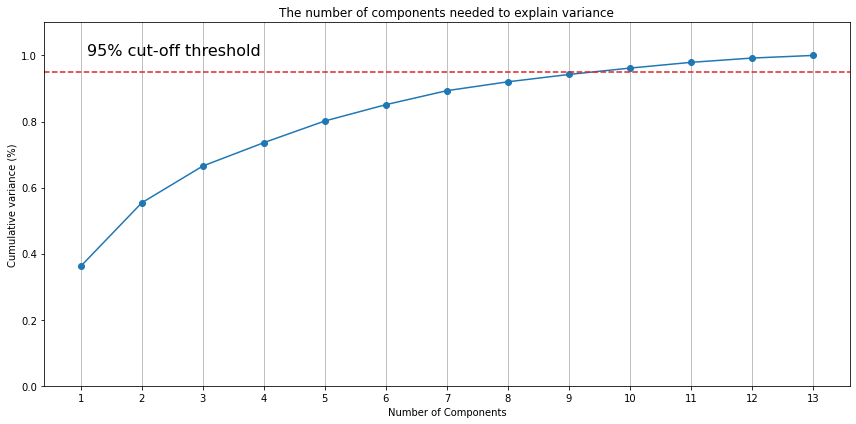

In [10]:
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(X)

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 14, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='tab:blue')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='tab:red', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

**Notes**: Another way to look at the exact same information above is to plot the cumulative explained variance showing how the curve flattens slightly around `6` or `7` components.  A line has been drawn for 95% total explained variance as stated above at approximatley `9` components.

**References:**
1. https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

## Plotting Each Component vs. Original Data

Next, we can plot each of the transformed data for each of the PCA component dimensions and visualize what the data looks like.  

In [11]:
def transform_pca(X, n):
    '''Function to perform a PCA fit on X and return a transformed and then inverse transformed
    set of data for a given (n) number of PCA components'''
    
    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))
    
    return X_new

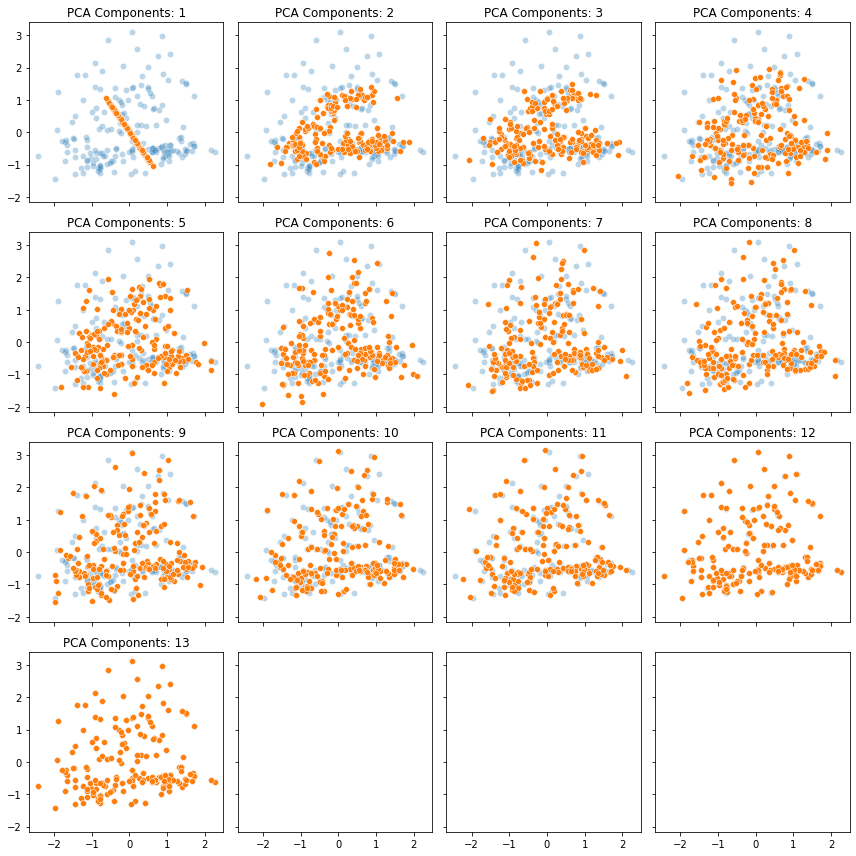

In [12]:
rows = 4
cols = 4
comps = 1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(12,12), 
                         sharex=True, 
                         sharey=True)


for row in range(rows):
    for col in range(cols):
        try:
            X_new = transform_pca(X_scaled, comps)
            ax = sns.scatterplot(x=X_scaled[:, 0], 
                                 y=X_scaled[:, 1], 
                                 ax=axes[row, col], 
                                 palette='tab20', 
                                 alpha=.3)
            ax = sns.scatterplot(x=X_new[:, 0], 
                                 y=X_new[:, 1], 
                                 ax=axes[row, col], 
                                 palette='tab20')
            ax.set_title(f'PCA Components: {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()
plt.savefig('pcavisualize_2.png', dpi=300)

**Notes**: With only a singular component, the dataset is transformed into a line represented but the first eigenvectors.  As the number of components increases, it becomes clear that the data starts to transform and look more like the original dataset.  Starting at `9` components, the two are generally indisinguishable from each other, this is the 95% threshold from above.

**References:**
1. https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

## Comparing PCA and Non-PCA Classification Models

The following section demonstrates the effects of PCA on a dataset with various classifiers.

1. **PCA vs. Non PCA**: Demonstrate three different classifiers `KNeighborsClassifier`, `RandomForestClassifier`, and `LogisticRegression` against the dataset. First without PCA and second with PCA (`n_components=2`).  Compare the Results.
1. **Model Optimization and Validation**: Using the `GridSearch` function, find the optimal parameters for our `n_components` and evaluate the final results.

In [13]:
y = df['Class'].copy()
X = df.drop(columns=['Class']).copy().values

In [14]:
def create_pipe(clf, do_pca=False, n=2):
    
    scaler = StandardScaler()
    pca = PCA(n_components=n)

    # Build estimator from PCA and Univariate selection:
    if do_pca == True:
        combined_features = FeatureUnion([("scaler", scaler), ("pca", pca)])
    else:
        combined_features = FeatureUnion([("scaler", scaler)])
    
    pipeline = Pipeline([("features", combined_features), ("clf", clf)])

     
    return pipeline

In [15]:
models = {'KNeighbors' : KNeighborsClassifier(),
          'RandomForest' : RandomForestClassifier(random_state=42),
          'LogisticReg' : LogisticRegression(multi_class='multinomial', 
                                             random_state=42),
          'Perceptron' : Perceptron(random_state=42)}


def run_models(with_pca):
    for name, model, in models.items():
        clf = model
        pipeline = create_pipe(clf, do_pca = with_pca, n=6)
        cv = RepeatedStratifiedKFold(n_splits=10, 
                                     n_repeats=5, 
                                     random_state=42)
        scores = cross_val_score(pipeline, X, 
                                 y, 
                                 scoring='accuracy', 
                                 cv=cv, n_jobs=1, 
                                 error_score='raise')
        print(name, ': Mean Accuracy: %.3f and Standard Deviation: (%.3f)' % \
            (np.mean(scores), np.std(scores)))

print(68 * '-')
print('Without PCA')
print(68 * '-')
run_models(False)
print(68 * '-')
print('With PCA')
print(68 * '-')
run_models(True)

--------------------------------------------------------------------
Without PCA
--------------------------------------------------------------------
KNeighbors : Mean Accuracy: 0.968 and Standard Deviation: (0.048)
RandomForest : Mean Accuracy: 0.984 and Standard Deviation: (0.025)
LogisticReg : Mean Accuracy: 0.985 and Standard Deviation: (0.025)
Perceptron : Mean Accuracy: 0.983 and Standard Deviation: (0.026)
--------------------------------------------------------------------
With PCA
--------------------------------------------------------------------
KNeighbors : Mean Accuracy: 0.708 and Standard Deviation: (0.088)
RandomForest : Mean Accuracy: 0.974 and Standard Deviation: (0.041)
LogisticReg : Mean Accuracy: 0.966 and Standard Deviation: (0.041)
Perceptron : Mean Accuracy: 0.664 and Standard Deviation: (0.212)


**Results**:  
1. `KNeighbors` and `Perceptron` both performed worse with the dimensions reduced `0.25-0.30` reduction in accuracy.
1. `RandomForest` and `LogisticRegression` only performed `~0.015` worse when the data was reduced to only `6` dimensions.

## Model Optimization and Validation

For this portion, we'll use the `train_test_split` function to split the dataset into `70/30%` partitions and then use the `GridSearch` feature to find optimal parameters.  The most critical parameter here that we want to validate is the performance of various **PCA component number** settings.   We will test the entire range from `1-13` and find the best setting.  As we saw from the scatterplots above, when we approach higher numbers like `9`, the dataset after transformation looks a lot like the original with `95%` of the variation explained by the transformed dataset.  

In [16]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

In [17]:
print(X_train.shape)
print(X_test.shape)

(124, 13)
(54, 13)


In [18]:
def get_params(parameters, X, y, pipeline):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    grid = GridSearchCV(pipeline, parameters, scoring='accuracy', n_jobs=1, cv=cv, error_score='raise')
    grid.fit(X, y)

    return grid

In [19]:
clf = LogisticRegression(random_state=41)
pipeline = create_pipe(clf, do_pca=True)

param_grid = dict(features__pca__n_components = list(range(1,14)),
                 clf__C = [0.1, 1.0, 10,],
                 clf__solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

grid = get_params(param_grid, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.981
Test set score: 0.944
Best parameters: {'clf__C': 1.0, 'clf__solver': 'liblinear', 'features__pca__n_components': 6}


## Model Validation

Perform a final fit and test with the new parameters.  One for our optimized Number of Components (`6`) and one for a set of data that has not had PCA performed on it.

In [20]:
def fit_and_print(pipeline, name):
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(name + '.png', dpi=300) 
    plt.show; 

              precision    recall  f1-score   support

           1      0.933     1.000     0.966        14
           2      1.000     0.864     0.927        22
           3      0.900     1.000     0.947        18

    accuracy                          0.944        54
   macro avg      0.944     0.955     0.947        54
weighted avg      0.949     0.944     0.944        54



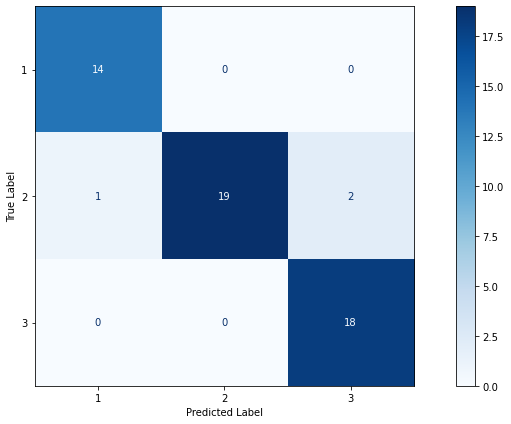

In [21]:
clf = LogisticRegression(C=1, solver='liblinear', random_state=41)
pipeline = create_pipe(clf, do_pca=True, n=6)
fit_and_print(pipeline, 'pcavisualize_3')

              precision    recall  f1-score   support

           1      1.000     1.000     1.000        14
           2      1.000     0.955     0.977        22
           3      0.947     1.000     0.973        18

    accuracy                          0.981        54
   macro avg      0.982     0.985     0.983        54
weighted avg      0.982     0.981     0.982        54



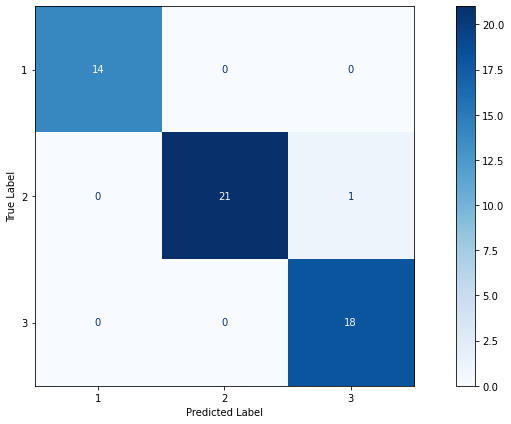

In [22]:
clf = LogisticRegression(C=1, solver='liblinear', random_state=41)
pipeline = create_pipe(clf, do_pca=False)
fit_and_print(pipeline, 'pcavisualize_4')

**Note**: `Accuracy` was chosen as our scoring metric for all cases since this dataset is balanced and we care about all classes equally.